# Calculating Variance #

In [2]:
import arrow
import datetime as dt
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import Variance_script as vs

In [3]:
working_dir = Path('/home/sallen/MEOPAR/Karyn_Reshapr/')

In [4]:
CSis, CSie, CSjs, CSje = 450, 500, 250, 300
JFis, JFie, JFjs, JFje = 300, 365, 50, 100
Nks, Nke = 0, 10
Pks, Pke = 0, 24
Zks, Zke = 0, 40

In [5]:
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
mesh = mesh.rename_dims({'z': 'depth', 'x': 'gridX', 'y': 'gridY'})
# Nitrate for Central SoG
e3t_CSOG = mesh.e3t_0[0, Nks:Nke, CSis:CSie, CSjs:CSje]
tmask = mesh.tmask[0, Nks:Nke, CSis:CSie, CSjs:CSje]
# Nitrate for JdF
e3t_JF = mesh.e3t_0[0, Nks:Nke, JFis:JFie, JFjs:JFje]
tmask_JF = mesh.tmask[0, Nks:Nke, JFis:JFie, JFjs:JFje]
# Phytoplankton for CSOG
e3t_CSOG_50 = mesh.e3t_0[0, Pks:Pke, CSis:CSie, CSjs:CSje]
tmask_CSOG_50 = mesh.tmask[0, Pks:Pke, CSis:CSie, CSjs:CSje]
# Phytoplankton for JdF
e3t_JF_50 = mesh.e3t_0[0, Pks:Pke, JFis:JFie, JFjs:JFje]
tmask_JF_50 = mesh.tmask[0, Pks:Pke, JFis:JFie, JFjs:JFje]
# Zooplankton for CSOG
e3t_CSOG_AD = mesh.e3t_0[0, :, CSis:CSie, CSjs:CSje]
tmask_CSOG_AD = mesh.tmask[0, :, CSis:CSie, CSjs:CSje]
# Zooplankton for JdF
e3t_JF_AD = mesh.e3t_0[0, :, JFis:JFie, JFjs:JFje]
tmask_JF_AD = mesh.tmask[0, :, JFis:JFie, JFjs:JFje]

### Diatoms ###

Slice wanted:
* 1 month, hourly
* top 50 m
* JdF 300:365 and 50:100
* CSoG 450:500 and 250:300

**Note:** you can specify your timescale on the command line

### Extracted Data Set ###
reshapr extract JdF_phyto.yaml

In [5]:
may15 = xr.open_dataset('/home/sallen/MEOPAR/Karyn_Reshapr/JdF_phyto_20150501_20150531.nc')
may15

<xarray.Dataset>
Dimensions:      (time: 744, depth: 24, gridY: 65, gridX: 50)
Coordinates:
  * time         (time) datetime64[ns] 2015-05-01T00:30:00 ... 2015-05-31T23:...
  * depth        (depth) float32 0.5 1.5 2.5 3.5 4.5 ... 24.1 28.23 34.69 44.52
  * gridY        (gridY) int64 300 301 302 303 304 305 ... 360 361 362 363 364
  * gridX        (gridX) int64 50 51 52 53 54 55 56 57 ... 93 94 95 96 97 98 99
Data variables:
    diatoms      (time, depth, gridY, gridX) float32 ...
    flagellates  (time, depth, gridY, gridX) float32 ...
Attributes:
    name:         JdF_phyto_20150501_20150531
    description:  Hourly phytoplankton for a month in JdF 0-10m extracted fro...
    history:      2025-07-21 11:06 -07:00: Generated by `reshapr extract /oce...
    Conventions:  CF-1.6

### Multiply by Thicknesses ###

<xarray.Dataset>
Dimensions:      (time: 744, depth: 24, gridY: 65, gridX: 50)
Coordinates:
  * time         (time) datetime64[ns] 2015-05-01T00:30:00 ... 2015-05-31T23:...
  * depth        (depth) float32 0.5 1.5 2.5 3.5 4.5 ... 24.1 28.23 34.69 44.52
  * gridY        (gridY) int64 300 301 302 303 304 305 ... 360 361 362 363 364
  * gridX        (gridX) int64 50 51 52 53 54 55 56 57 ... 93 94 95 96 97 98 99
Data variables:
    diatoms      (time, depth, gridY, gridX) float64 nan 0.0 0.0 ... 0.0 0.0 0.0
    flagellates  (time, depth, gridY, gridX) float64 nan 0.0 0.0 ... 0.0 0.0 0.0


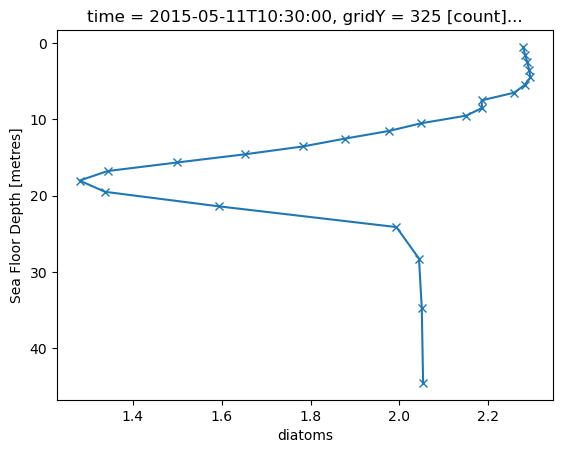

In [6]:
print (may15 * e3t_JF_50)
(may15 * e3t_JF_50).diatoms[250, :, 25, 25].plot(y='depth', yincrease=False, marker='x');

### Multiply by Thicknesses and Sum over Depth, Masking using tmask, and divide by Depth again masked ###

<xarray.DataArray 'diatoms' ()>
array(0.92618675)
Coordinates:
    time     datetime64[ns] 2015-05-11T10:30:00
    gridY    int64 325
    gridX    int64 75


<xarray.Dataset>
Dimensions:      (time: 744, gridY: 65, gridX: 50)
Coordinates:
  * time         (time) datetime64[ns] 2015-05-01T00:30:00 ... 2015-05-31T23:...
  * gridY        (gridY) int64 300 301 302 303 304 305 ... 360 361 362 363 364
  * gridX        (gridX) int64 50 51 52 53 54 55 56 57 ... 93 94 95 96 97 98 99
Data variables:
    diatoms      (time, gridY, gridX) float64 nan nan nan nan ... nan nan nan
    flagellates  (time, gridY, gridX) float64 nan nan nan nan ... nan nan nan

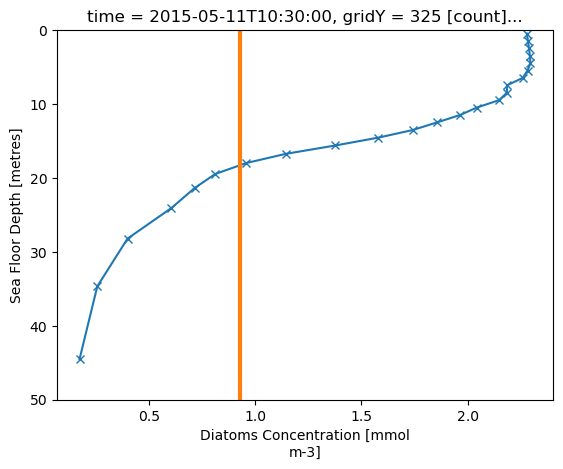

In [8]:
calcul = (may15 * e3t_JF_50).where(tmask_JF_50 ==1).sum(dim='depth') / (e3t_JF_50.where(tmask_JF_50 ==1).sum(dim='depth'))
may15.diatoms[250, :, 25, 25].plot(y='depth', yincrease=False, marker='x');
plt.plot([calcul.diatoms[250, 25, 25], calcul.diatoms[250, 25, 25]], [50, 0], linewidth=3);
plt.ylim(50, 0)
print (calcul.diatoms[250, 25, 25])
calcul

### Multiply by Thicknesses and Sum over Depth, Masking using tmask, and divide by Depth again masked and Find Variances ###

In [24]:
var_may15 = calcul.var().diatoms.item()
print (calcul.where(tmask_JF_50[0] ==1).var().diatoms.item())
vart_may15 = calcul.mean(dim='gridX').mean(dim='gridY').var().diatoms.item()
print (calcul.where(tmask_JF_50[0] ==1).mean(dim='gridX').mean(dim='gridY').var().diatoms.item())
varS_may15 = calcul.mean(dim='time').var().diatoms.item()
print (calcul.mean(dim='time').where(tmask_JF_50[0] ==1).var().diatoms.item())
mean_may15 = calcul.mean(dim='gridX').mean(dim='gridY').mean(dim='time').diatoms.item()
print (var_may15, vart_may15, varS_may15, mean_may15)

0.7047271011402487
0.03143656239198765
0.5581515722105844
0.7047271011402487 0.03143656239198765 0.5581515722105844 1.091897811802243


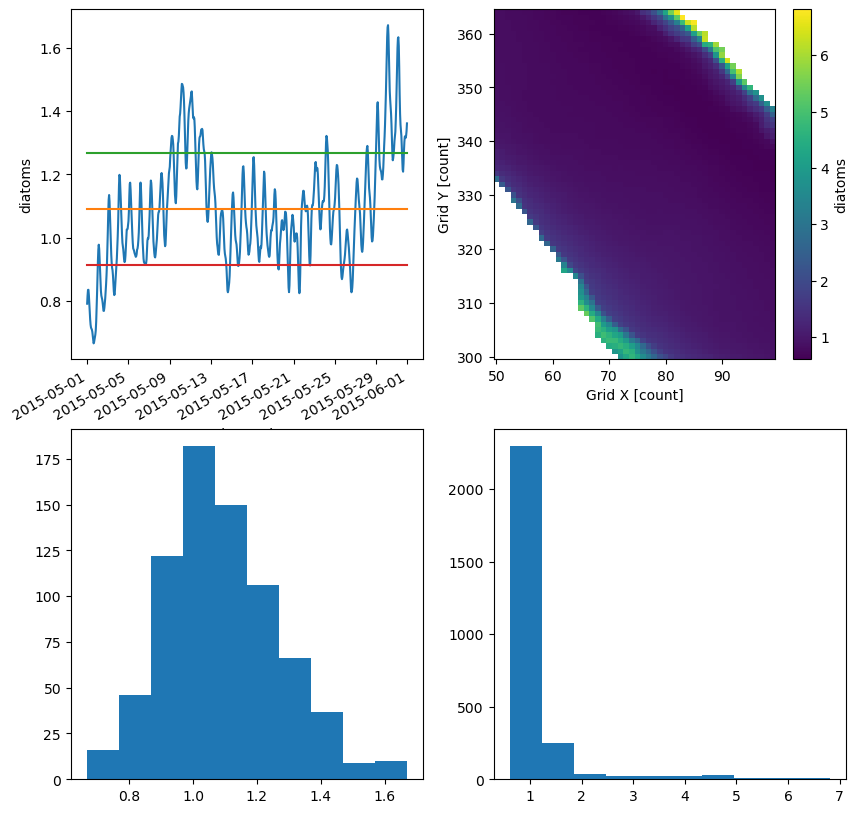

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
calcul.mean(dim='gridX').mean(dim='gridY').diatoms.plot(ax=axs[0, 0]);

axs[0, 0].plot([dt.datetime(2015,5, 1), dt.datetime(2015,6, 1)], np.ones((2))*mean_may15)
axs[0, 0].plot([dt.datetime(2015,5, 1), dt.datetime(2015,6, 1)], np.ones((2))*(mean_may15+np.sqrt(vart_may15)))
axs[0, 0].plot([dt.datetime(2015,5, 1), dt.datetime(2015,6, 1)], np.ones((2))*(mean_may15-np.sqrt(vart_may15)))

calcul.mean(dim='time').diatoms.plot(ax=axs[0, 1]);

axs[1, 0].hist(calcul.mean(dim='gridX').mean(dim='gridY').diatoms);
axs[1, 1].hist(calcul.mean(dim='time').diatoms.values.flatten());

# Loop Through the Months #

In [14]:
JdF_phyto = pd.read_csv('JdF_phyto_2007_2022.csv')

In [25]:
def plot_variance(variance, title, variables, depth, size=192):
    fig, axs = plt.subplots(1, 2, figsize=(15, 4))
    for ix, variable in enumerate(variables):
        axs[ix].plot(2007+np.arange(size)/12, variance[f'{variable} variance'], label='Total Variance')
        axs[ix].plot(2007+np.arange(size)/12,variance[f'{variable} variance space'], label='Spatial Variance')
        axs[ix].plot(2007+np.arange(size)/12,variance[f'{variable} variance time'], label='Temporal Variance')
        axs[ix].legend(loc='best')
        axs[ix].set_title(f'{variable} (depth averaged to {depth})')
    
    fig.suptitle(title);

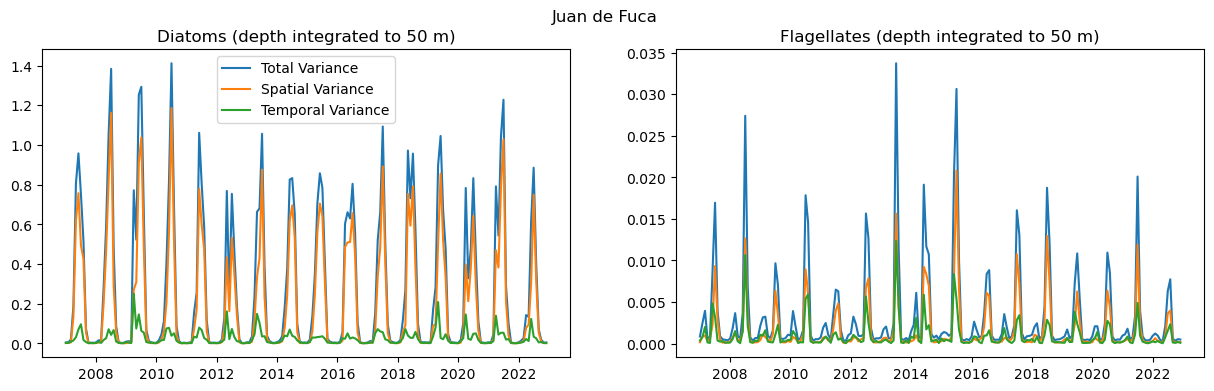

In [15]:
plot_variance(JdF_phyto, 'Juan de Fuca')

In [ ]:
stem = 'CSOG_phyto'
variable = ['diatoms', 'flagellates']
 
variance = find_variances(stem, variable, ['diatoms variance', 'flagellates variance'], e3t_CSOG_50, tmask_CSOG_50)

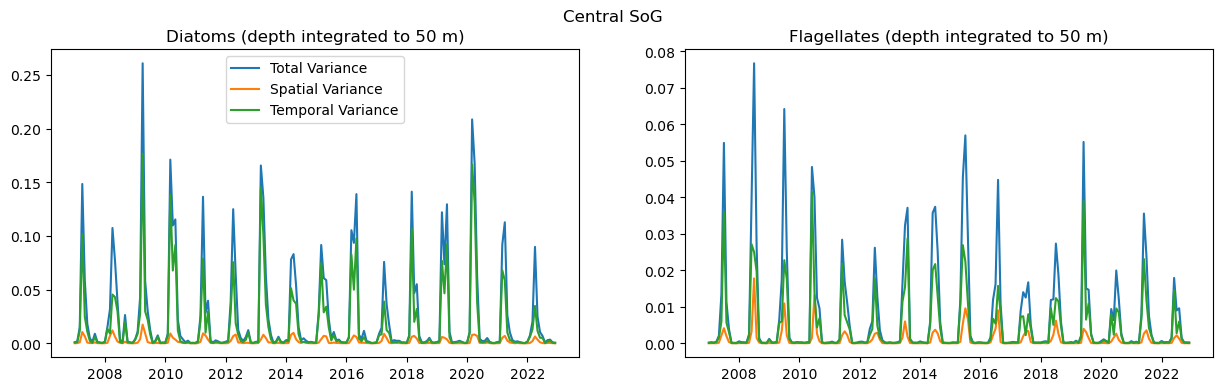

In [51]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].plot(2007+np.arange(192)/12, variance['diatoms variance'], label='Total Variance')
axs[0].plot(2007+np.arange(192)/12,variance['diatoms variance space'], label='Spatial Variance')
axs[0].plot(2007+np.arange(192)/12,variance['diatoms variance time'], label='Temporal Variance')
axs[0].legend(loc='best')
axs[0].set_title('Diatoms (depth integrated to 50 m)')

axs[1].plot(2007+np.arange(192)/12,variance['flagellates variance'])
axs[1].plot(2007+np.arange(192)/12,variance['flagellates variance space'])
axs[1].plot(2007+np.arange(192)/12,variance['flagellates variance time'])
axs[1].set_title('Flagellates (depth integrated to 50 m)')

fig.suptitle('Central SoG');

In [52]:
variance.to_csv('CSOG_phyto_2007_2022.csv')

Index(['Unnamed: 0', 'Year', 'Month', 'nitrate variance',
       'nitrate variance time', 'nitrate variance space'],
      dtype='object')


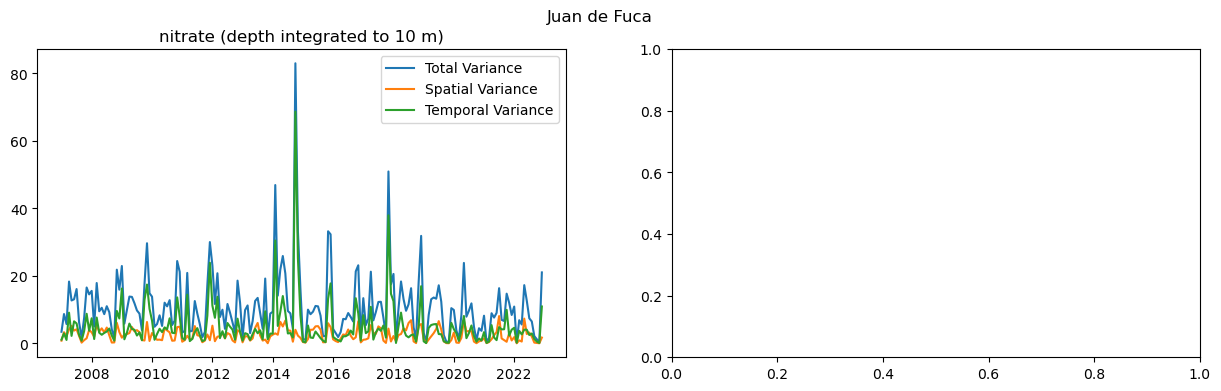

In [20]:
JdF_nitrate = pd.read_csv('JdF_nitrate_2007_2022.csv')
print (JdF_nitrate.keys())
plot_variance(JdF_nitrate, 'Juan de Fuca', ['nitrate'], '10 m')

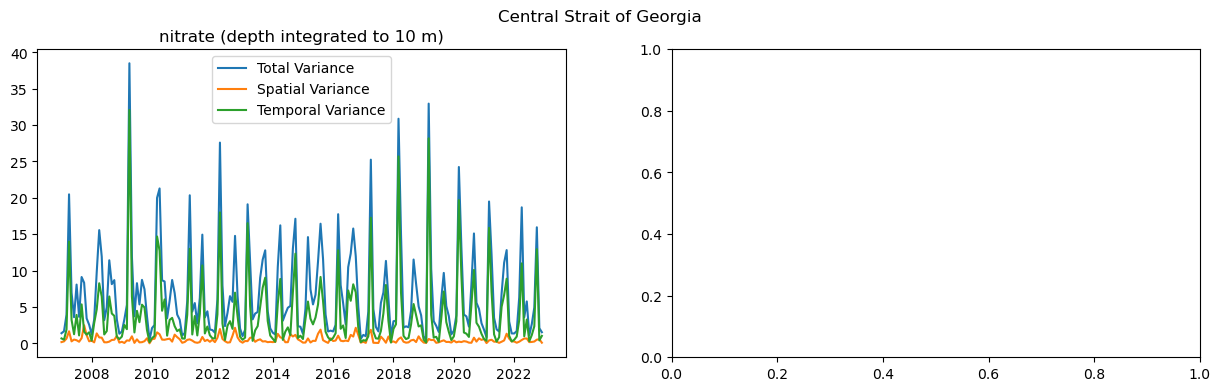

In [21]:
CSOG_nitrate = pd.read_csv('CSOG_nitrate_2007_2022.csv')
plot_variance(CSOG_nitrate, 'Central Strait of Georgia', ['nitrate'], '10 m')

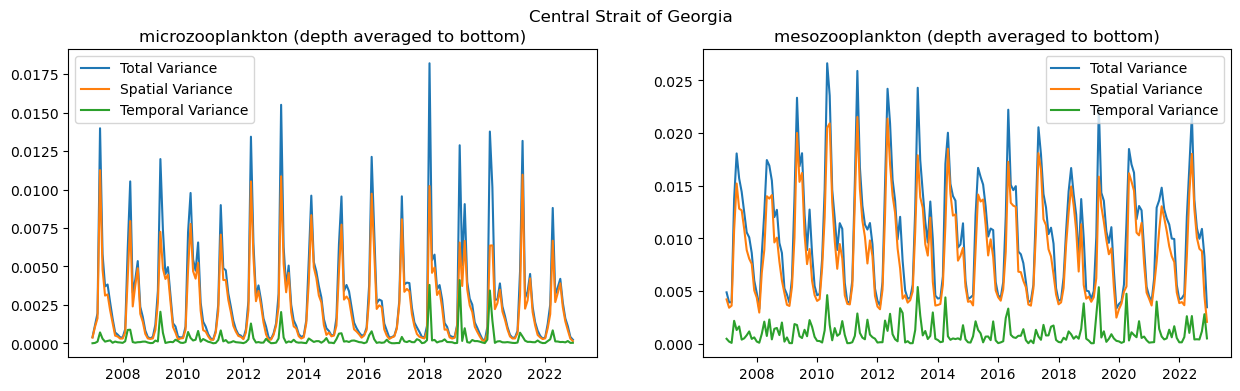

In [26]:
CSOG_zoo = pd.read_csv('CSOG_zoo_2007_2022.csv')
plot_variance(CSOG_zoo, 'Central Strait of Georgia', ['microzooplankton', 'mesozooplankton'], 'bottom')

In [ ]:
variance.to_csv('JdF_nitrate_2007_2022.csv')

In [ ]:
variance = find_variances('JdF_phyto', ['diatoms', 'flagellates'], 
                          ['diatom variance', 'nanoflagellate variance'], e3w_JF_50, tmask_JF_50)

In [ ]:
variance

In [ ]:
base_file = xr.open_dataset('/results2/SalishSea/nowcast-green.202111/07jul25/SalishSea_1h_20250707_20250707_biol_T.nc')
base_file

In [ ]:
data.close()

In [ ]:
apr10 = xr.open_dataset('/home/sallen/MEOPAR/Karyn_Reshapr/JdF_phyto_20100401_20100430.nc')

In [ ]:
apr10.diatoms[15, :, 25, 25].plot()
(apr10 * e3w_JF_50).diatoms[15, :, 25, 25].plot()
print (apr10.diatoms[15, :, 25, 25].mean().values)
print ((apr10 * e3w_JF_50).diatoms[15, :, 25, 25].mean().values)
print ((apr10 * e3w_JF_50).diatoms[15, :, 25, 25].mean().values/e3w_JF_50[:, 25, 25].mean().values)
print ((apr10 * e3w_JF_50).diatoms[15, :, 25, 25].sum().values/e3w_JF_50[:, 25, 25].sum().values)

In [ ]:
jan15.nitrate[15, :, 25, 25].mean()

In [ ]:
((jan15 * e3w_CSOG).nitrate[15, :, 25, 25].mean(dim='depth')/e3w_CSOG[:, 25, 25].mean())

In [ ]:
print (e3w_JF_50[:, 25, 25])

In [ ]:
print (mesh.e3w_0[0, :, 530, 250].values)

In [ ]:
print (mesh.gdepw_0[0, :, 530, 250].values)

In [ ]:
for ii in range(26):
    print (mesh.e3t_0[0, :ii+1, 530, 250].sum().values)

In [ ]:
d = arrow.get('2025-07-16')
print(f'{d:YYYYMMDD}')

In [47]:
5+6

11